In [1]:
import io
import cv2

import numpy as np
import random 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from datetime import datetime
# import torch
# import torch.nn as nn
# from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv')
df = df.drop(columns=['Open', 'Low', 'High'])
df = df.set_index('Date')
df

,Close,PE_CAPE
Date,,
1960-01-04,59.910000,18.338285
1960-01-05,60.389999,18.338285
1960-01-06,60.130001,18.338285
1960-01-07,59.689999,18.338285
1960-01-08,59.500000,18.338285
...,...,...
2021-12-27,4791.190000,38.660000
2021-12-28,4786.350000,38.660000
2021-12-29,4793.060000,38.660000


In [3]:
date = df.index.to_numpy()
close = df['Close'].to_numpy()
pe = df['PE_CAPE'].to_numpy()
close_lag = []
pe_lag = []
r = []
for i in range(180, len(close)):
    x = close[i-180:i]
    y = pe[i-180:i]
    close_lag.append(x)
    pe_lag.append(y)
    r.append(pearsonr(x, y)[0])
close_lag = np.array(close_lag)
pe_lag = np.array(pe_lag)
r = np.array(r)
close_value = close[180:]
pe_value = pe[180:]

In [4]:
from scipy.signal import argrelextrema
time = ['1960-01-01']
money = [1]
i = 0
while i < len(close_value):
    if r[i] > 0.9:
        buy = close_lag[i, argrelextrema(close_lag[i,:], np.less)[0][0]]
        sell = close_value[i]
        money.append(money[-1] * sell / buy)
        time.append(date[180+i])
        i += 180
    else:
        i += 1

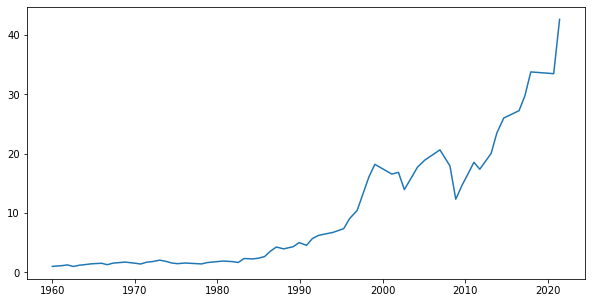

In [5]:
plt.figure(figsize=(10,5))
plt.plot(np.array(time).astype('datetime64'), money)

In [6]:
v = 0
prn = set()
while v < len(close_value):
    mini = argrelextrema(close_lag[v,:], np.less)[0]
    maxi = argrelextrema(close_lag[v,:], np.greater)[0]
    i = 0; j = 1; k = 0
    while j < len(maxi) and k < len(mini):
        if mini[k] < maxi[j]:
            k += 1
            continue
        if close_lag[v, maxi[i]] < close_lag[v, maxi[j]] and close_lag[v, maxi[j]] < close_lag[v, maxi[-1]]:
            # diff within 1%
            if abs(close_lag[v, maxi[i]] - close_lag[v, mini[k]]) < 0.01 * close_lag[v, maxi[i]]:
                prn.add(v)
        i += 1
        j += 1
    v += 1

In [7]:
abcd = []
for v in prn:    
    if close_lag[v,-1] == np.max(close_lag[v,:]):
        abcd.append(v)
len(abcd)

1644

In [8]:
oos = list(set([i for i in range(len(close_value))]) - prn)
len(oos)

2135

In [9]:
# def fig2img(fig, dpi=180):
#     buf = io.BytesIO()
#     fig.savefig(buf, format="png", dpi=dpi)
#     buf.seek(0)
#     img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
#     buf.close()
#     img = cv2.imdecode(img_arr, 1)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.resize(img,(50,50),interpolation = cv2.INTER_AREA).astype(np.uint8)

#     return img

# data = []
# plt.figure(figsize=(5,5))
# for i in oos:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# for i in abcd:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# for i in dcba:
#     fig = plt.gcf()
#     plt.plot(range(180), close_lag[i,:])
#     plt.axis('off');
#     data.append(fig2img(fig).flatten())
#     plt.clf()
# data = np.array(data)
# np.save('data', data)

In [10]:
# labels = np.array([0]*len(oos) + [1]*len(abcd) + [2]*len(dcba))
# np.save('labels', labels)

(3779, 2500) (3779,)


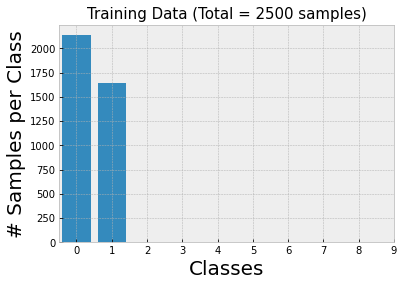

In [11]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from tensorflow.keras.layers import BatchNormalization
from numpy import mean, std
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Loading Data
data = np.load('data.npy')
labels = np.load('labels.npy')
data_train = data
labels_train = labels
print(data_train.shape, labels_train.shape)

# Counting number samples per class
vals, counts = np.unique(labels_train, return_counts=True)

plt.bar(vals, counts)
plt.xticks(range(10),range(10))
plt.xlabel('Classes',size=20)
plt.ylabel('# Samples per Class', size=20)
plt.title('Training Data (Total = '+str(data_train.shape[1])+' samples)',size=15);

In [12]:
df_test = df['2014-01-01':]
close_test = df_test['Close'].to_numpy()
pe_test = df_test['PE_CAPE'].to_numpy()
date_test = df_test.index.to_numpy()
cmin = close_test.min()
cmax = close_test.max()
close_test = (close_test - cmin) / (cmax - cmin)
pe_test = (pe_test - pe_test.min()) / (pe_test.max() - pe_test.min())

In [13]:
close_lag_test = []
pe_lag_test = []
for i in range(180, len(close_test)):
    close_lag_test.append(close_test[i-180:i])
    pe_lag_test.append(pe_test[i-180:i])
close_lag_test = np.array(close_lag_test)
pe_lag_test = np.array(pe_lag_test)
close_value_test = close_test[180:]
date_test = date_test[180:]

In [14]:
word_dict = {0:'SEll',1:'HOLD'}
import argparse
import skimage as sk
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from skimage import transform
from skimage import util
from sklearn.preprocessing import StandardScaler, label_binarize
import cv2



# load train and test dataset
def load_dataset():
    # load dataset
    kernel = np.ones((4,4),np.uint8)
    trainX, testX, trainY, testY = train_test_split(data_train, labels_train, test_size = 0.25, stratify=labels_train)
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 50, 50, 1))
    testX = testX.reshape((testX.shape[0], 50, 50, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
#     testY = to_categorical(testY)
    print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(data):
    # convert from integers to floats
    data = data.astype('float32')
    # he_uniformize to range 0-1
    data = (255.0 - (data))
    data = data/255.0
    # return he_uniformized images
    return data
 
# define cnn model
def define_model(learn_rate=0.0001, eps=1e-7, dropout_rate=0.5):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(50, 50, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten(name='feat_cnn'))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = Adam(learning_rate=learn_rate , epsilon=eps)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, tes_X, tes_y,n_folds=20):
    scores, histories = list(), list()

#     parameters = {'batch_size': [16], 'epochs': [25], 'dropout_rate': [0.5], 
#                   'learn_rate' : [0.0001],
#                   'eps' : [1e-7]}
    model = define_model()
    print("Model Defined")
    model.fit(dataX, dataY,epochs=10, batch_size=16)
    y_pr = model.predict(tes_X)[:,0]
    y_pr[y_pr>0.5]=0.5
    y_pr[y_pr<0.5]=1
    y_pr[y_pr==0.5]=0
    print("Confusion Matrix :-  ",confusion_matrix(tes_y,y_pr))
    return model,scores, histories
 
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset

    trainX, trainY, testX, testY = load_dataset()
    # evaluate model
    model, scores, histories = evaluate_model(trainX, trainY, testX, testY)

    return model
# entry point, run the test harness
cnn = run_test_harness()

(2834, 50, 50, 1) (2834, 2) (945, 50, 50, 1) (945,)


2022-04-08 22:47:59.718748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 22:48:00.260791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79125 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:b7:00.0, compute capability: 8.0
2022-04-08 22:48:01.041056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model Defined
Epoch 1/10


2022-04-08 22:48:02.049247: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-04-08 22:48:02.922385: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-04-08 22:48:03.008911: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-04-08 22:48:04.052796: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


178/178 [==============================] - 5s 5ms/step - loss: 1.4933 - accuracy: 0.7996
Epoch 2/10
178/178 [==============================] - 1s 6ms/step - loss: 0.7435 - accuracy: 0.8941
Epoch 3/10
178/178 [==============================] - 0s 2ms/step - loss: 0.5596 - accuracy: 0.9273
Epoch 4/10
178/178 [==============================] - 0s 2ms/step - loss: 0.4617 - accuracy: 0.9365
Epoch 5/10
178/178 [==============================] - 0s 2ms/step - loss: 0.3261 - accuracy: 0.9460
Epoch 6/10
178/178 [==============================] - 0s 2ms/step - loss: 0.3185 - accuracy: 0.9485
Epoch 7/10
178/178 [==============================] - 0s 2ms/step - loss: 0.2615 - accuracy: 0.9584
Epoch 8/10
178/178 [==============================] - 0s 2ms/step - loss: 0.2446 - accuracy: 0.9548
Epoch 9/10
178/178 [==============================] - 0s 2ms/step - loss: 0.1798 - accuracy: 0.9661
Epoch 10/10
178/178 [==============================] - 0s 2ms/step - loss: 0.1826 - accuracy: 0.9633
Confusion 

In [15]:
img_train = []
for i in range(1, 15):
    k = np.load(f'img_train_{i*1000}.npy')
    img_train += list(k)

img_train = np.array(img_train)
img_train = img_train.reshape(((img_train.shape[0], 50, 50, 1)))

In [16]:
df_train = df['1960-01-01':'2014-12-31']
df_train = (df_train - df_train.min()) / (df_train.max() - df_train.min())

In [17]:
close_train = df_train['Close'].to_numpy()
pe_train = df_train['PE_CAPE'].to_numpy()
date_train = df_train.index.to_numpy()
close_lag_train = []
pe_lag_train = []
for i in range(180, len(close_train)):
    close_lag_train.append(close_train[i-180:i])
    pe_lag_train.append(pe_train[i-180:i])
close_lag_train = np.array(close_lag_train)
pe_lag_train = np.array(pe_lag_train)
close_value_train = close_train[180:]
date_train = date_train[180:]

In [18]:
tm = df['1960-01-01':'2014-12-31']
tm = tm['Close'].to_numpy()
tmax = tm.max()
tmin = tm.min()

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
import tensorflow as tf
def set_seed(seed):  
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
def rnn(shape, lr=0.001, eps=1e-7, dop=0.4):
    set_seed(42)
    model = Sequential()
    model.add(GRU(128, input_shape=shape, return_sequences=True, activation='tanh'))
    model.add(Dropout(dop))
    model.add(GRU(128, activation='tanh'))
    model.add(Dropout(dop))
    model.add(Dense(1))
    opt = Adam(learning_rate=lr , epsilon=eps)
    model.compile(loss='mean_squared_error',  optimizer=opt,metrics = ['mse', 'mae'])
    return model

In [20]:
trainX = np.hstack((close_lag_train, pe_lag_train, cnn.predict(img_train)))
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))

In [21]:
model = rnn((trainX.shape[1], 1), lr=0.001)
model.fit(trainX, close_value_train, epochs=25, batch_size=64)

Epoch 1/25
214/214 [==============================] - 7s 23ms/step - loss: 0.0399 - mse: 0.0399 - mae: 0.1507
Epoch 2/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0385 - mse: 0.0385 - mae: 0.1479
Epoch 3/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0371 - mse: 0.0371 - mae: 0.1442
Epoch 4/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0327 - mse: 0.0327 - mae: 0.1287
Epoch 5/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0321 - mse: 0.0321 - mae: 0.1259
Epoch 6/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0315 - mse: 0.0315 - mae: 0.1235
Epoch 7/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0268 - mse: 0.0268 - mae: 0.1130
Epoch 8/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1122
Epoch 9/25
214/214 [==============================] - 5s 22ms/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0570
Epoch 10/2

In [22]:
img_test = np.load('img_test.npy')
img_test = img_test.reshape((img_test.shape[0], 50, 50, 1))

In [23]:
def train_error(pr, act):
    pr = pr*(tmax - tmin) + tmin
    act = act*(tmax - tmin) + tmin
    err = (abs(pr[0] - act))
    err = np.divide(err, act)
    return err
def test_error(pr, act):
    pr = pr*(cmax - cmin) + cmin
    act = act*(cmax - cmin) + cmin
    err = (abs(pr[0] - act))
    err = np.divide(err, act)
    return err

In [24]:
feat_cnn = cnn.predict(img_test)
train_cnn = cnn.predict(img_train)

In [25]:
def test_predict(data, model=model):
    testX = np.hstack((data, pe_lag_test, feat_cnn))
    testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
    testY = model.predict(testX)
    return testY
def train_predict(data, model=model):
    trainX = np.hstack((data, pe_lag_train, train_cnn))
    trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
    trainY = model.predict(trainX)
    return trainY

In [26]:
train_day1 = train_predict(close_lag_train)
error_train_day1 = train_error(train_day1, close_value_train)

In [27]:
tlag2 = np.hstack((close_lag_train, train_day1))
tlag2 = tlag2[:,1:]
train_day2 = train_predict(tlag2)
error_train_day2 = train_error(train_day2[:-1],close_value_train[1:])

In [28]:
tlag3 = np.hstack((tlag2, train_day2))
tlag3 = tlag3[:,1:]
train_day3 = train_predict(tlag3)
error_train_day3 = train_error(train_day3[:-2],close_value_train[2:])

In [29]:
tlag4 = np.hstack((tlag3, train_day3))
tlag4 = tlag2[:,1:]
train_day4 = train_predict(tlag4)
error_train_day4 = train_error(train_day4[:-3],close_value_train[3:])

In [30]:
day1 = test_predict(close_lag_test)
error_test_day1 = test_error(day1, close_value_test)

In [31]:
lag2 = np.hstack((close_lag_test, day1))
lag2 = lag2[:,1:]
day2 = test_predict(lag2)
error_test_day2 = test_error(day2[:-1], close_value_test[1:])

In [32]:
lag3 = np.hstack((lag2, day2))
lag3 = lag3[:,1:]
day3 = test_predict(lag3)
error_test_day3 = test_error(day3[:-2], close_value_test[2:])

In [33]:
lag4 = np.hstack((lag3, day3))
lag4 = lag4[:,1:]
day4 = test_predict(lag4)
error_test_day4 = test_error(day4[:-3], close_value_test[3:])

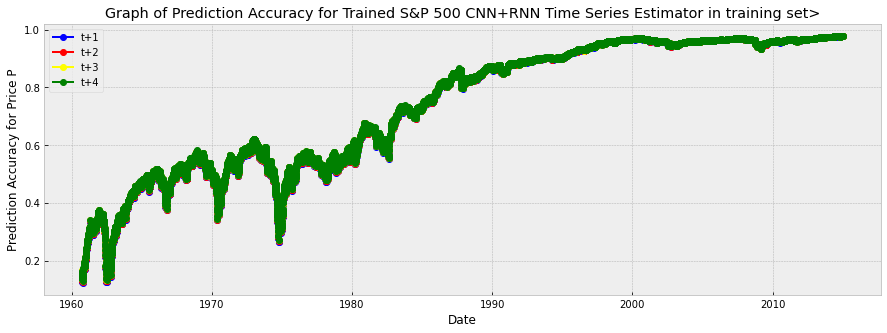

In [34]:
plt.figure(figsize=(15, 5));
plt.plot(date_train.astype('datetime64'), error_train_day1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_train[1:].astype('datetime64'), error_train_day2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_train[2:].astype('datetime64'), error_train_day3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_train[3:].astype('datetime64'), error_train_day4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator in training set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

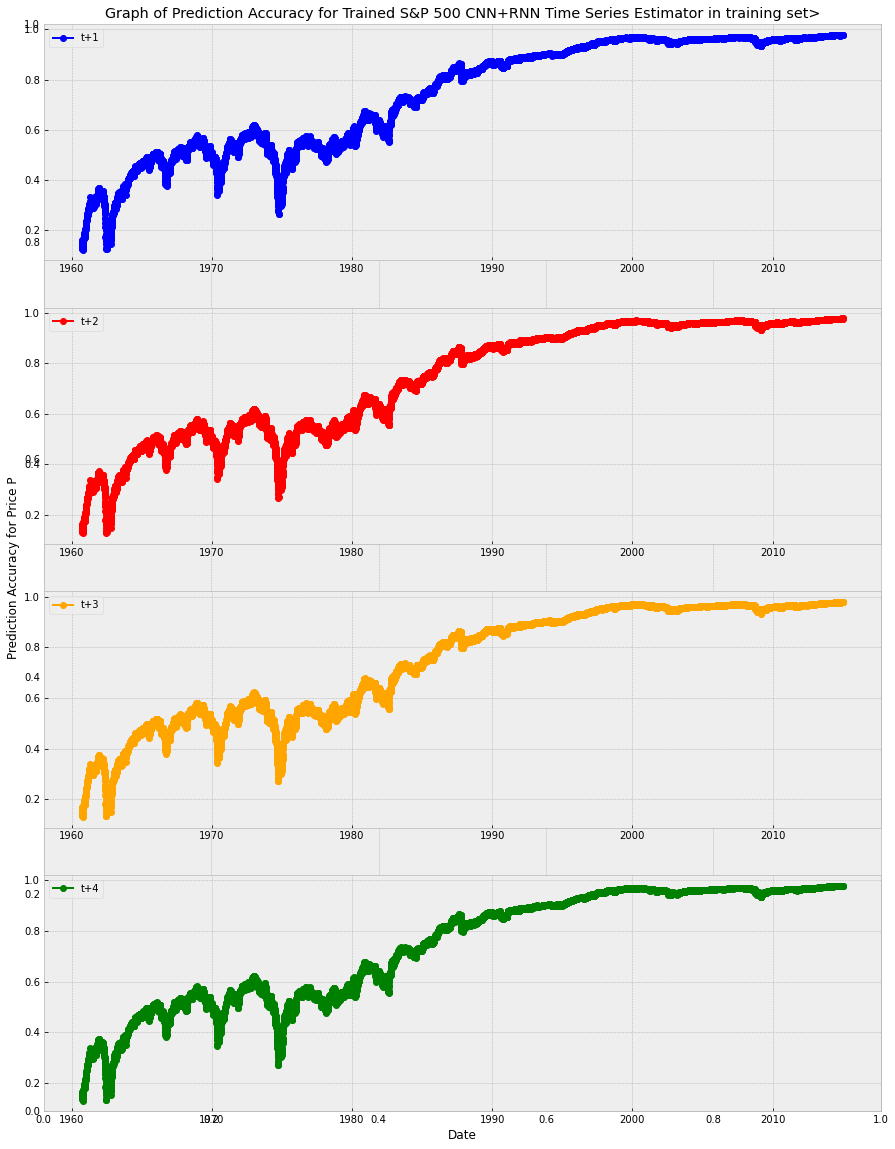

In [35]:
fig = plt.figure(figsize=(15, 20));
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator in training set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
fig.add_subplot(4, 1, 1)
plt.plot(date_train.astype('datetime64'), error_train_day1, color = 'blue', label = 't+1', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 2)
plt.plot(date_train[1:].astype('datetime64'), error_train_day2, color = 'red', label = 't+2', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 3)
plt.plot(date_train[2:].astype('datetime64'), error_train_day3, color = 'orange', label = 't+3', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 4)
plt.plot(date_train[3:].astype('datetime64'), error_train_day4, color = 'green', label = 't+4', marker= 'o')
plt.legend()
plt.show()

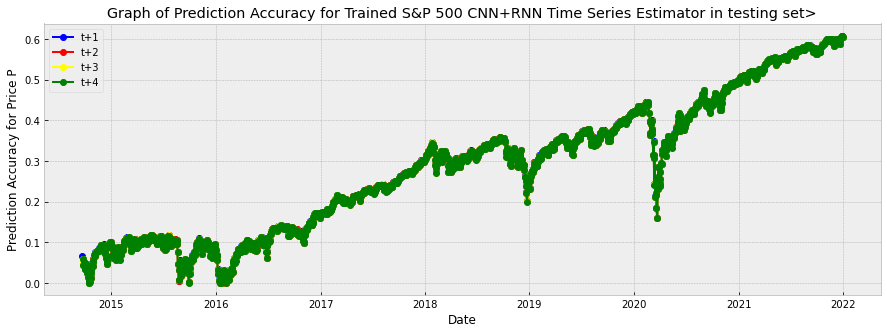

In [36]:
plt.figure(figsize=(15, 5));
plt.plot(date_test.astype('datetime64'), error_test_day1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_test[1:].astype('datetime64'), error_test_day2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_test[2:].astype('datetime64'), error_test_day3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_test[3:].astype('datetime64'), error_test_day4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator in testing set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

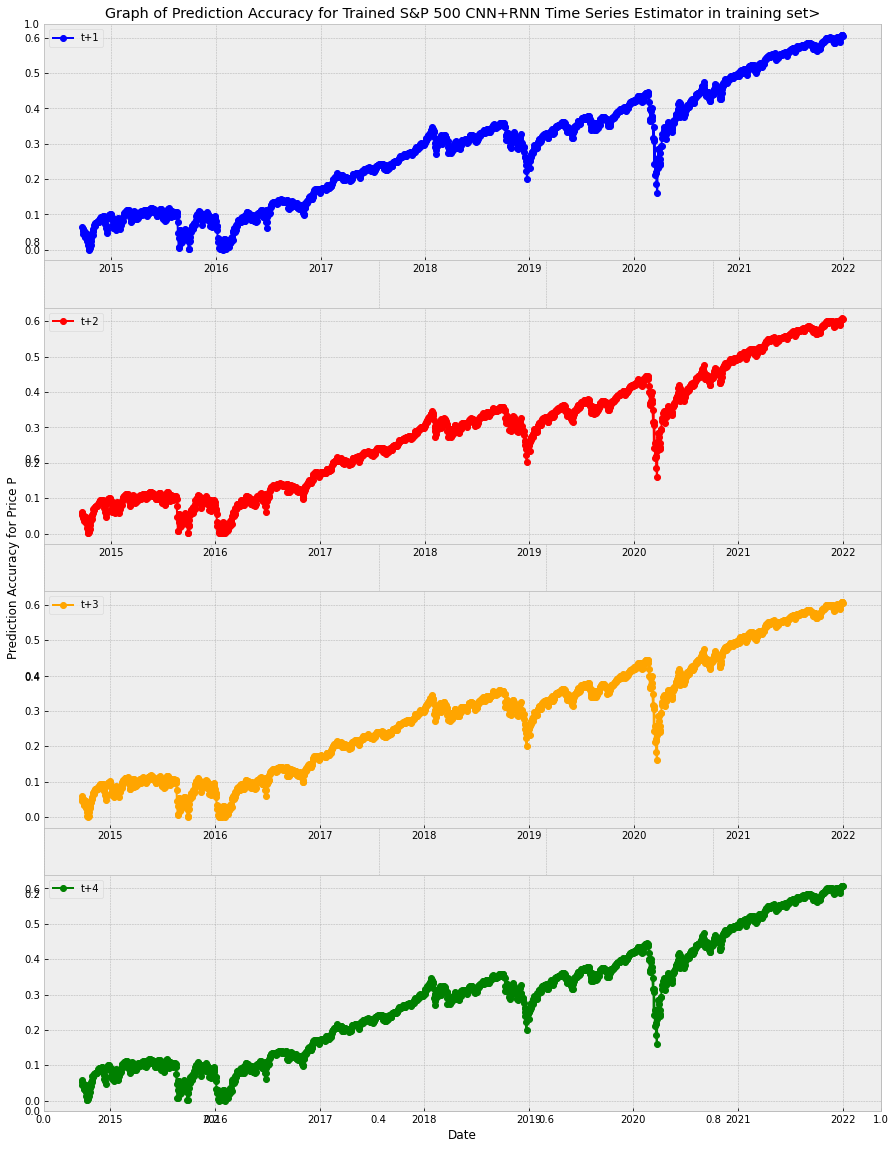

In [37]:

fig = plt.figure(figsize=(15, 20));
plt.title('Graph of Prediction Accuracy for Trained S&P 500 CNN+RNN Time Series Estimator in training set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
fig.add_subplot(4, 1, 1)
plt.plot(date_test.astype('datetime64'), error_test_day1, color = 'blue', label = 't+1', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 2)
plt.plot(date_test[1:].astype('datetime64'), error_test_day2, color = 'red', label = 't+2', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 3)
plt.plot(date_test[2:].astype('datetime64'), error_test_day3, color = 'orange', label = 't+3', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 4)
plt.plot(date_test[3:].astype('datetime64'), error_test_day4, color = 'green', label = 't+4', marker= 'o')
plt.legend()
plt.show()

## To improve the model we increased the batch size from 64 to 128 and increased the learning rate from 0.001 to 0.005 to speed up the learning process.

In [38]:
model = rnn((trainX.shape[1], 1), lr=0.005)
model.fit(trainX, close_value_train, epochs=25, batch_size=128)

Epoch 1/25
107/107 [==============================] - 4s 25ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.1568
Epoch 2/25
107/107 [==============================] - 3s 24ms/step - loss: 0.0360 - mse: 0.0360 - mae: 0.1385
Epoch 3/25
107/107 [==============================] - 3s 24ms/step - loss: 0.0382 - mse: 0.0382 - mae: 0.1424
Epoch 4/25
107/107 [==============================] - 3s 24ms/step - loss: 0.0108 - mse: 0.0108 - mae: 0.0670
Epoch 5/25
107/107 [==============================] - 3s 24ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0312
Epoch 6/25
107/107 [==============================] - 3s 24ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0277
Epoch 7/25
107/107 [==============================] - 3s 25ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0257
Epoch 8/25
107/107 [==============================] - 3s 26ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0239
Epoch 9/25
107/107 [==============================] - 3s 26ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0233
Epoch 10/2

In [39]:
train_day1 = train_predict(close_lag_train)
error_train_day1 = train_error(train_day1, close_value_train)

In [40]:
tlag2 = np.hstack((close_lag_train, train_day1))
tlag2 = tlag2[:,1:]
train_day2 = train_predict(tlag2)
error_train_day2 = train_error(train_day2[:-1],close_value_train[1:])

In [41]:
tlag3 = np.hstack((tlag2, train_day2))
tlag3 = tlag3[:,1:]
train_day3 = train_predict(tlag3)
error_train_day3 = train_error(train_day3[:-2],close_value_train[2:])

In [42]:
tlag4 = np.hstack((tlag3, train_day3))
tlag4 = tlag2[:,1:]
train_day4 = train_predict(tlag4)
error_train_day4 = train_error(train_day4[:-3],close_value_train[3:])

In [43]:
day1 = test_predict(close_lag_test)
error_test_day1 = test_error(day1, close_value_test)

In [44]:
lag2 = np.hstack((close_lag_test, day1))
lag2 = lag2[:,1:]
day2 = test_predict(lag2)
error_test_day2 = test_error(day2[:-1], close_value_test[1:])

In [45]:
lag3 = np.hstack((lag2, day2))
lag3 = lag3[:,1:]
day3 = test_predict(lag3)
error_test_day3 = test_error(day3[:-2], close_value_test[2:])

In [46]:
lag4 = np.hstack((lag3, day3))
lag4 = lag4[:,1:]
day4 = test_predict(lag4)
error_test_day4 = test_error(day4[:-3], close_value_test[3:])

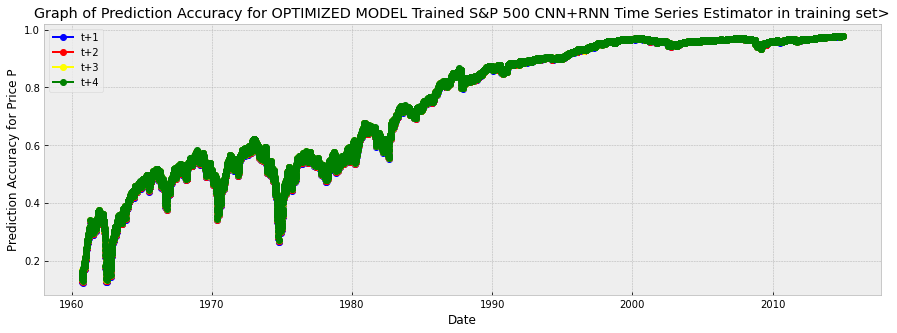

In [47]:
plt.figure(figsize=(15, 5));
plt.plot(date_train.astype('datetime64'), error_train_day1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_train[1:].astype('datetime64'), error_train_day2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_train[2:].astype('datetime64'), error_train_day3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_train[3:].astype('datetime64'), error_train_day4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for OPTIMIZED MODEL Trained S&P 500 CNN+RNN Time Series Estimator in training set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

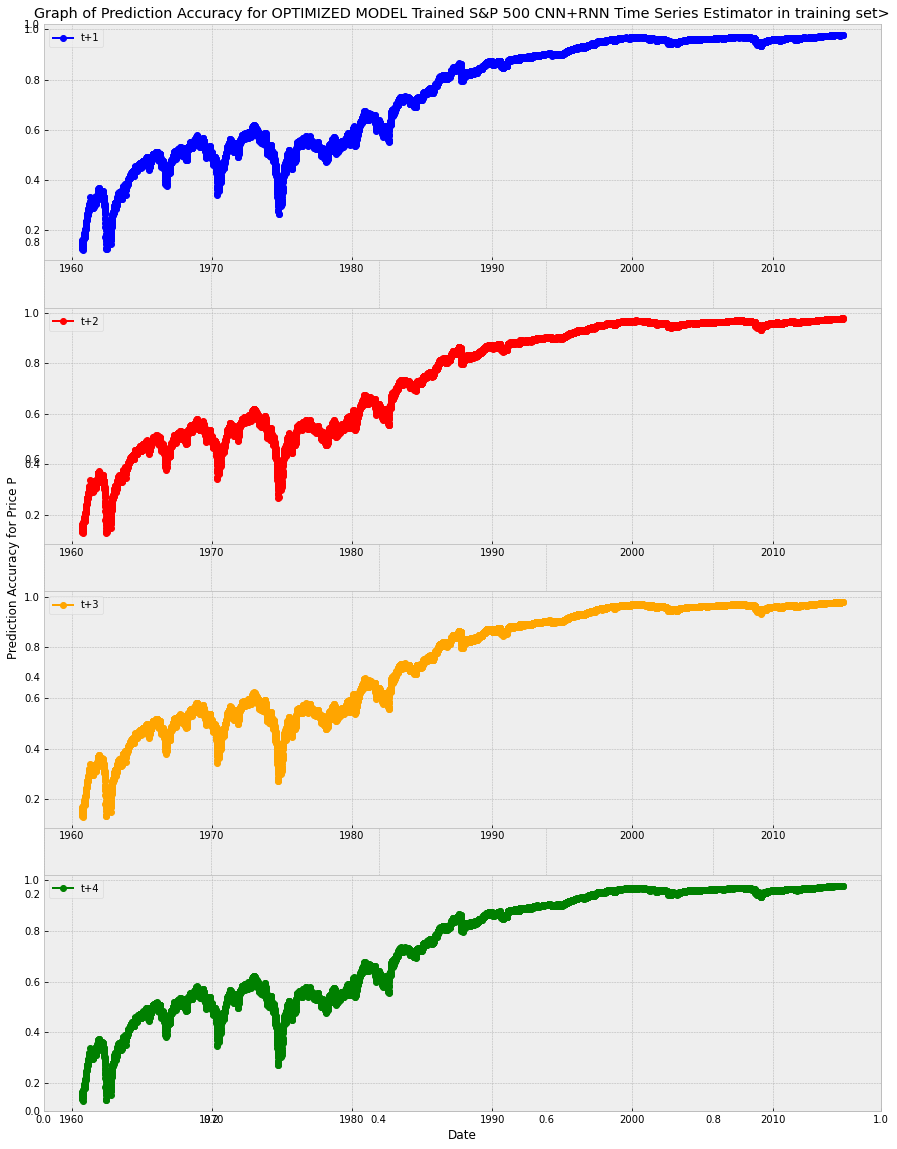

In [48]:
fig = plt.figure(figsize=(15, 20));
plt.title('Graph of Prediction Accuracy for OPTIMIZED MODEL Trained S&P 500 CNN+RNN Time Series Estimator in training set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
fig.add_subplot(4, 1, 1)
plt.plot(date_train.astype('datetime64'), error_train_day1, color = 'blue', label = 't+1', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 2)
plt.plot(date_train[1:].astype('datetime64'), error_train_day2, color = 'red', label = 't+2', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 3)
plt.plot(date_train[2:].astype('datetime64'), error_train_day3, color = 'orange', label = 't+3', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 4)
plt.plot(date_train[3:].astype('datetime64'), error_train_day4, color = 'green', label = 't+4', marker= 'o')
plt.legend()
plt.show()

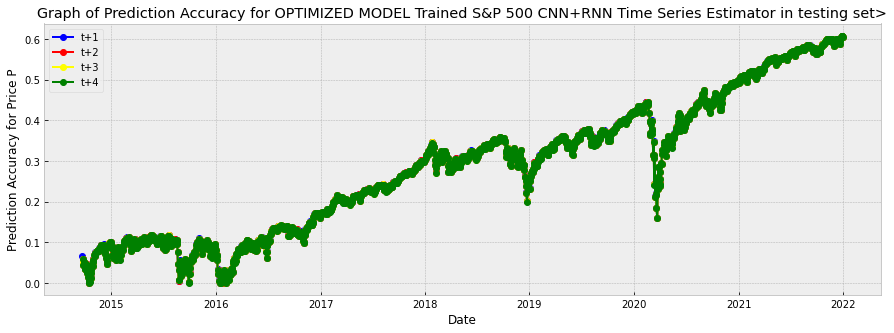

In [49]:
plt.figure(figsize=(15, 5));
plt.plot(date_test.astype('datetime64'), error_test_day1, color = 'blue', label = 't+1', marker= 'o')
plt.plot(date_test[1:].astype('datetime64'), error_test_day2, color = 'red', label = 't+2', marker= 'o')
plt.plot(date_test[2:].astype('datetime64'), error_test_day3, color = 'yellow', label = 't+3', marker= 'o')
plt.plot(date_test[3:].astype('datetime64'), error_test_day4, color = 'green', label = 't+4', marker= 'o')
plt.title('Graph of Prediction Accuracy for OPTIMIZED MODEL Trained S&P 500 CNN+RNN Time Series Estimator in testing set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
plt.legend()
plt.show()

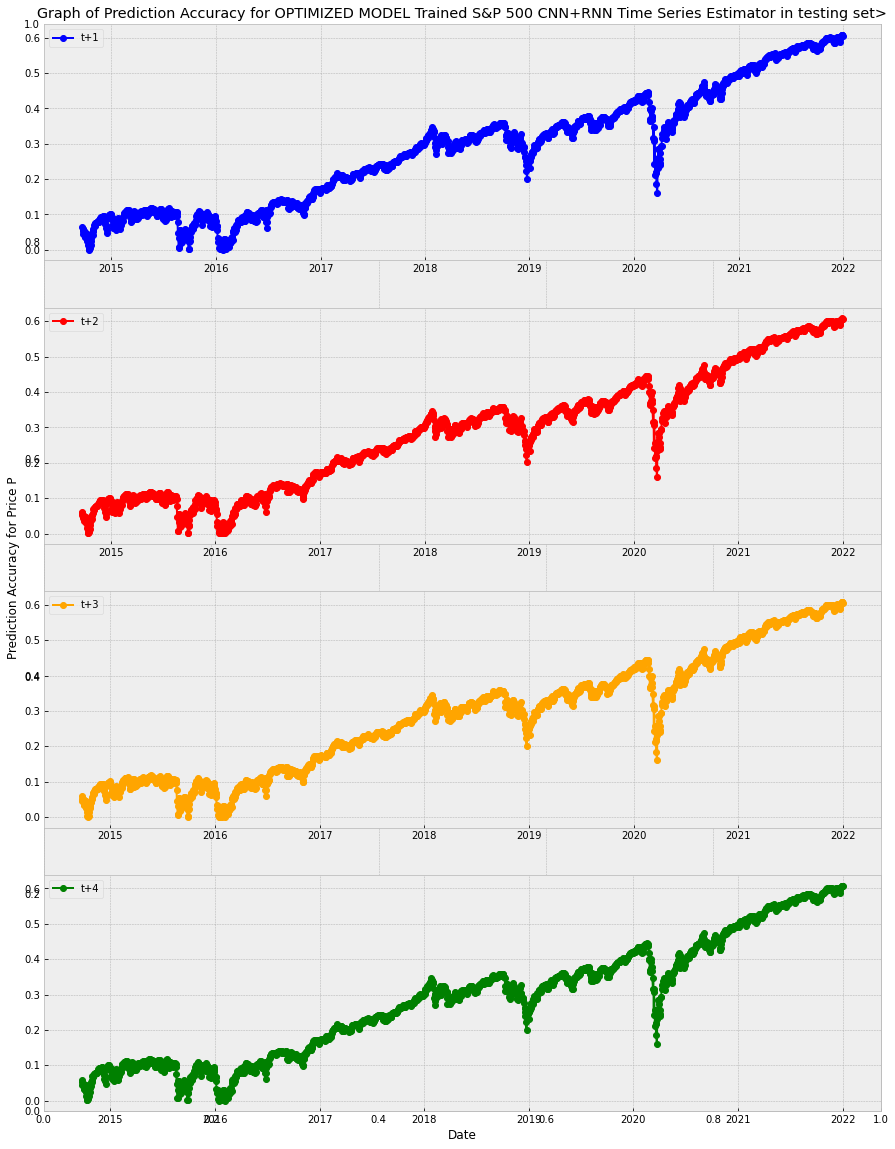

In [50]:

fig = plt.figure(figsize=(15, 20));
plt.title('Graph of Prediction Accuracy for OPTIMIZED MODEL Trained S&P 500 CNN+RNN Time Series Estimator in testing set>')
plt.xlabel('Date')
plt.ylabel('Prediction Accuracy for Price P')
fig.add_subplot(4, 1, 1)
plt.plot(date_test.astype('datetime64'), error_test_day1, color = 'blue', label = 't+1', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 2)
plt.plot(date_test[1:].astype('datetime64'), error_test_day2, color = 'red', label = 't+2', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 3)
plt.plot(date_test[2:].astype('datetime64'), error_test_day3, color = 'orange', label = 't+3', marker= 'o')
plt.legend()
fig.add_subplot(4, 1, 4)
plt.plot(date_test[3:].astype('datetime64'), error_test_day4, color = 'green', label = 't+4', marker= 'o')
plt.legend()
plt.show()

In [51]:
def train_inv(data):
    return (data*(tmax - tmin) + tmin)
def test_inv(data):
    return (data*(cmax - cmin) + cmin)
time = ['1960-01-01']
money = [1]
i = 0
while i < len(close_value_train):
    if train_cnn[i,1] > 0.5:
        buy = train_inv(close_lag_train[i, argrelextrema(close_lag_train[i,:], np.less)[0][0]])
        sell = train_inv(close_value_train[i])
        money.append(money[-1] * sell / buy)
        time.append(date_train[i])
        i += 180
    else:
        i += 1

In [52]:
i = 0
while i < len(close_value_test):
    if feat_cnn[i,1] > 0.5:
        buy = test_inv(close_lag_test[i, argrelextrema(close_lag_test[i,:], np.less)[0][0]])
        sell = test_inv(close_value_test[i])
        money.append(money[-1] * sell / buy)
        time.append(date_test[i])
        i += 180
    else:
        i += 1

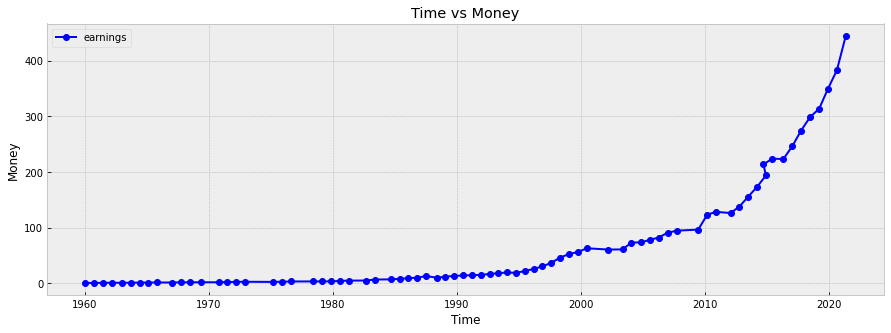

In [53]:
plt.figure(figsize=(15, 5));
plt.plot(np.array(time).astype('datetime64'), money, color = 'blue', label = 'earnings', marker= 'o')
plt.title('Time vs Money')
plt.xlabel('Time')
plt.ylabel('Money')
plt.legend()
plt.show()